# Process

To save operation reseouces, the project only assigned sentiment scores to the corresponding sentence indices when saving LLM's results. Accordingly, the states list and sentences were merged into newly retrieved dataset with sentiment scores.

In [29]:
import pandas as pd
import ast
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
scores = pd.read_csv("../data/layer1/layer1_sentiment.csv")
sentences = pd.read_csv("../data/layer1/layer1_sentence.csv")

sentences["index"] = sentences.index
merged = pd.merge(scores, sentences, on='index', how="left")

In [8]:
# inspect the data
print(merged.info())
print(merged.head(3))
merged.to_csv("../data/layer1/layer1_merged.csv",encoding="utf-8",index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38688 entries, 0 to 38687
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      38688 non-null  int64 
 1   sentiment  38688 non-null  int64 
 2   sentence   38688 non-null  object
 3   states     38688 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
None
   index  sentiment                                           sentence  \
0      0         -1  Ukraine war briefing: Zelenskyy vows his count...   
1      1          1  Ukraine’s President Volodymyr Zelenskyy has vo...   
2      2         -1  Ukraine has been allowing Russia to pipe gas t...   

                  states  
0  ['Russia', 'Ukraine']  
1  ['Russia', 'Ukraine']  
2  ['Russia', 'Ukraine']  


# Sample
According to the Cochran's formula, the project sampled 269 items ((e=0.05, p=0.5, Z=1.645/90% CI, N=38688)) from the dataset, and categorized the samples into Positive, Negative and Neutral sentiments manually. By comparing the results of the human annotation with those of the LLM, a 3*3 multi-class confusion matrix was generated.

Furthermore, the project also calculated Precision, Recall and F1 for each category and the overall performance. Take the positive category as an example, 

TP: Sentences classified as positive by both the LLM and the human annotator.
FP: Sentences classified as positive by the LLM but identified as non-positive by the human.
TN: Sentences classified as non-positive by both the LLM and the human.
FN: Sentences classified as non-positive by the LLM but identified as positive by the human.

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN}$$

$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

The metrices for the overall model was calculated through the arithmetic mean of the three categories.

In [7]:
sample = merged.sample(n=269, random_state=22)
sample.to_csv("../data/sample/sentiment_sample.csv",encoding="utf-8",index=False)

In [ ]:
# TODO Assessment

# Sentiment Aggregation
In this stage, sentiment scores were aggregated at the level of specific state-pairs based on the sentences where they appeared.

In [ ]:
merged = pd.read_csv("../data/layer1/layer1_merged.csv")

def parse_states(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

merged['states_list'] = merged['states'].apply(parse_states)

# generate pairs
pairs = []
for _, row in merged.iterrows():
    countries = row['states_list']
    sentiment = row['sentiment']
#     if not isinstance(countries, list) or len(countries) < 2:
#         continue
    # sort to avoid repeating the same states
    uniq = sorted(set(countries))
    for a, b in itertools.combinations(uniq, 2):
        pairs.append((a, b, sentiment))

pair_df = pd.DataFrame(pairs, columns=['s1', 's2', 'score'])
pair_scores = pair_df.groupby(['s1', 's2'], as_index=False)['score'].sum()
print(pair_scores.head(3))
pair_scores.to_csv('../data/layer1/layer1_pair_scores_all.csv', encoding='utf-8', index=False)

      country1                  country2  score
0  Afghanistan                   Bahrain      0
1  Afghanistan                   Belarus     -3
2  Afghanistan  Central African Republic     -1
3  Afghanistan                     China     -1
4  Afghanistan                  Colombia     -1


##  Inspection
1. Positive sentiments
According to the observation of the initial scores, the distribution is too discrete with large gaps; thus, the project further log-transformed the data to smoothen the distribution. However, the data still diverges irregularly, indicating the inherent structural imbalance of the layer.

2. Negative sentiments
The same situation exists in the negatively-linked pairs.

In [ ]:
pair_scores = pd.read_csv('../data/layer1/layer1_pair_scores_all.csv')

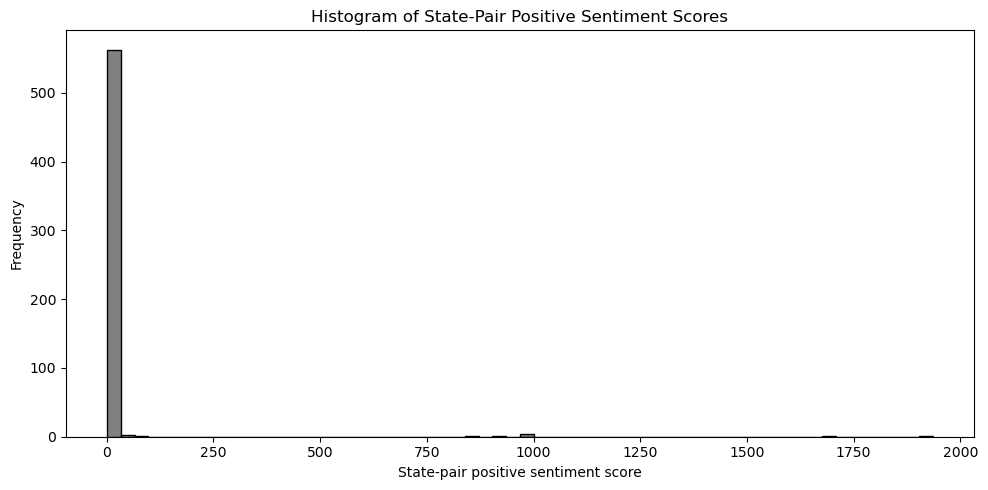

In [ ]:
# positive
scores_pos = pair_scores.loc[pair_scores['score'] > 0, 'score'].astype(int)

plt.figure(figsize=(10, 5))
plt.hist(scores_pos, bins=60, color='grey', edgecolor='black')
plt.xlabel('State-pair positive sentiment score')
plt.ylabel('Frequency')
plt.title('Histogram of State-Pair Positive Sentiment Scores')
plt.tight_layout()
plt.show()

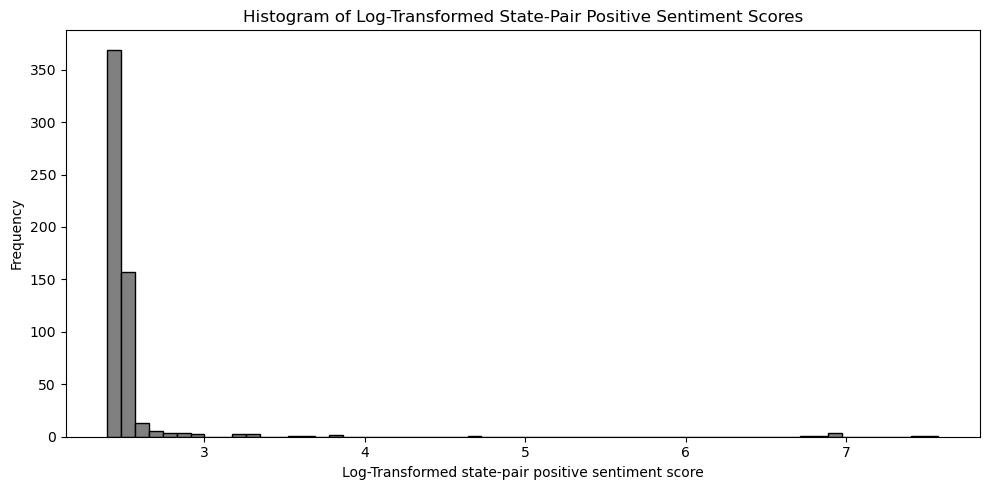

In [41]:
log_pos = np.log(scores_pos + 10)
plt.figure(figsize=(10, 5))
plt.hist(log_pos, bins=60, color='grey', edgecolor='black')
plt.xlabel('Log-Transformed state-pair positive sentiment score')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed State-Pair Positive Sentiment Scores')
plt.tight_layout()
plt.show()

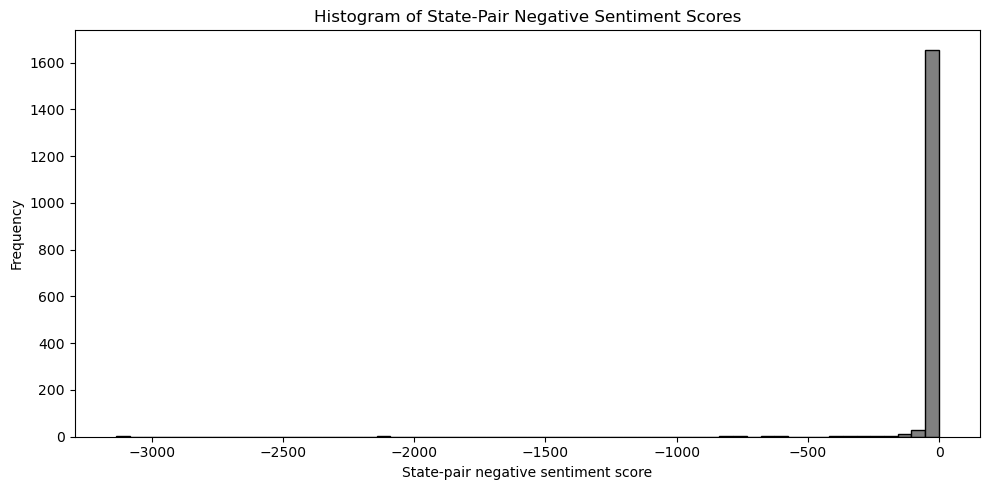

In [45]:
# negative
scores_pos = pair_scores.loc[pair_scores['score'] < 0, 'score'].astype(int)

plt.figure(figsize=(10, 5))
plt.hist(scores_pos, bins=60, color='grey', edgecolor='black')
plt.xlabel('State-pair negative sentiment score')
plt.ylabel('Frequency')
plt.title('Histogram of State-Pair Negative Sentiment Scores')
plt.tight_layout()
plt.show()

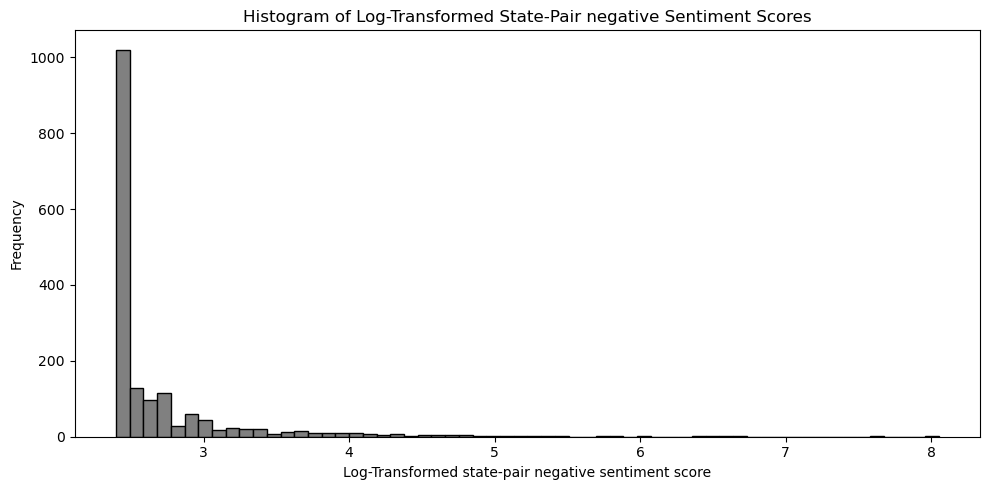

In [46]:
log_neg = np.log(-scores_pos + 10)
plt.figure(figsize=(10, 5))
plt.hist(log_neg, bins=60, color='grey', edgecolor='black')
plt.xlabel('Log-Transformed state-pair negative sentiment score')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed State-Pair negative Sentiment Scores')
plt.tight_layout()
plt.show()